In [52]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from instron_processing import ureg, Q_
import instron_processing.instron_processing as ip
import pint
import pint_pandas

ureg = pint.get_application_registry()
ureg.setup_matplotlib()
ureg.formatter.default_format = 'P~'
ureg.mpl_formatter = "{:~P}"

# Homogeneous Samples

The v2 versions of the homogeneous samples are the ones we went forward with, which gives us ~30:1 stiffness ratio in the XY-plane

In [54]:
dense_v1 = ip.load_samples('./homogeneous_foams/250309',
                           lambda f: 'dense' in f.stem.lower() and 'v1' in f.stem.lower())
sparse_v1 = ip.load_samples('./homogeneous_foams/250309',
                            lambda f: 'sparse' in f.stem.lower() and 'v1' in f.stem.lower())
dense_v2 = ip.load_samples('./homogeneous_foams/250309',
                           lambda f: 'dense' in f.stem.lower() and 'v2' in f.stem.lower())
sparse_v2 = ip.load_samples('./homogeneous_foams/250309',
                            lambda f: 'sparse' in f.stem.lower() and 'v2' in f.stem.lower())


samples = [dense_v1, sparse_v1, dense_v2, sparse_v2]

for group in samples:
    for s in group:
        m, b = s.add_linear_fit(x='Compressive strain (Displacement)',
                                y='Compressive stress',
                                x_min=0.,
                                x_max=10 * ureg.percent)
        s.user_data = dict(
            E=m.to('MPa'),
            y_intercept=b,
            comp_dir=s.results_tables[0]['Compression Axis']
        )

Loading csv files from ./homogeneous_foams/250309
9 found that match the filter
Loading csv files from ./homogeneous_foams/250309
9 found that match the filter
Loading csv files from ./homogeneous_foams/250309
9 found that match the filter


Loading csv files from ./homogeneous_foams/250309
9 found that match the filter


In [55]:
# Define sample types and directions
sample_types = ['dense_v1', 'sparse_v1', 'dense_v2', 'sparse_v2']
directions = ['X', 'Y', 'Z']
nrows = len(sample_types)
ncols = len(directions)

# Create a structured array to organize samples
organized_samples = np.empty((nrows, ncols), dtype=object)
for i in range(nrows):
    for j in range(ncols):
        organized_samples[i, j] = []

# Fill the array with samples
for i, group in enumerate(samples):
    for sample in group:
        dir_name = sample.user_data['comp_dir']
        dir_idx = {'X': 0, 'Y': 1, 'Z': 2}.get(
            dir_name, 0)  # Default to X if unknown
        organized_samples[i, dir_idx].append(sample)

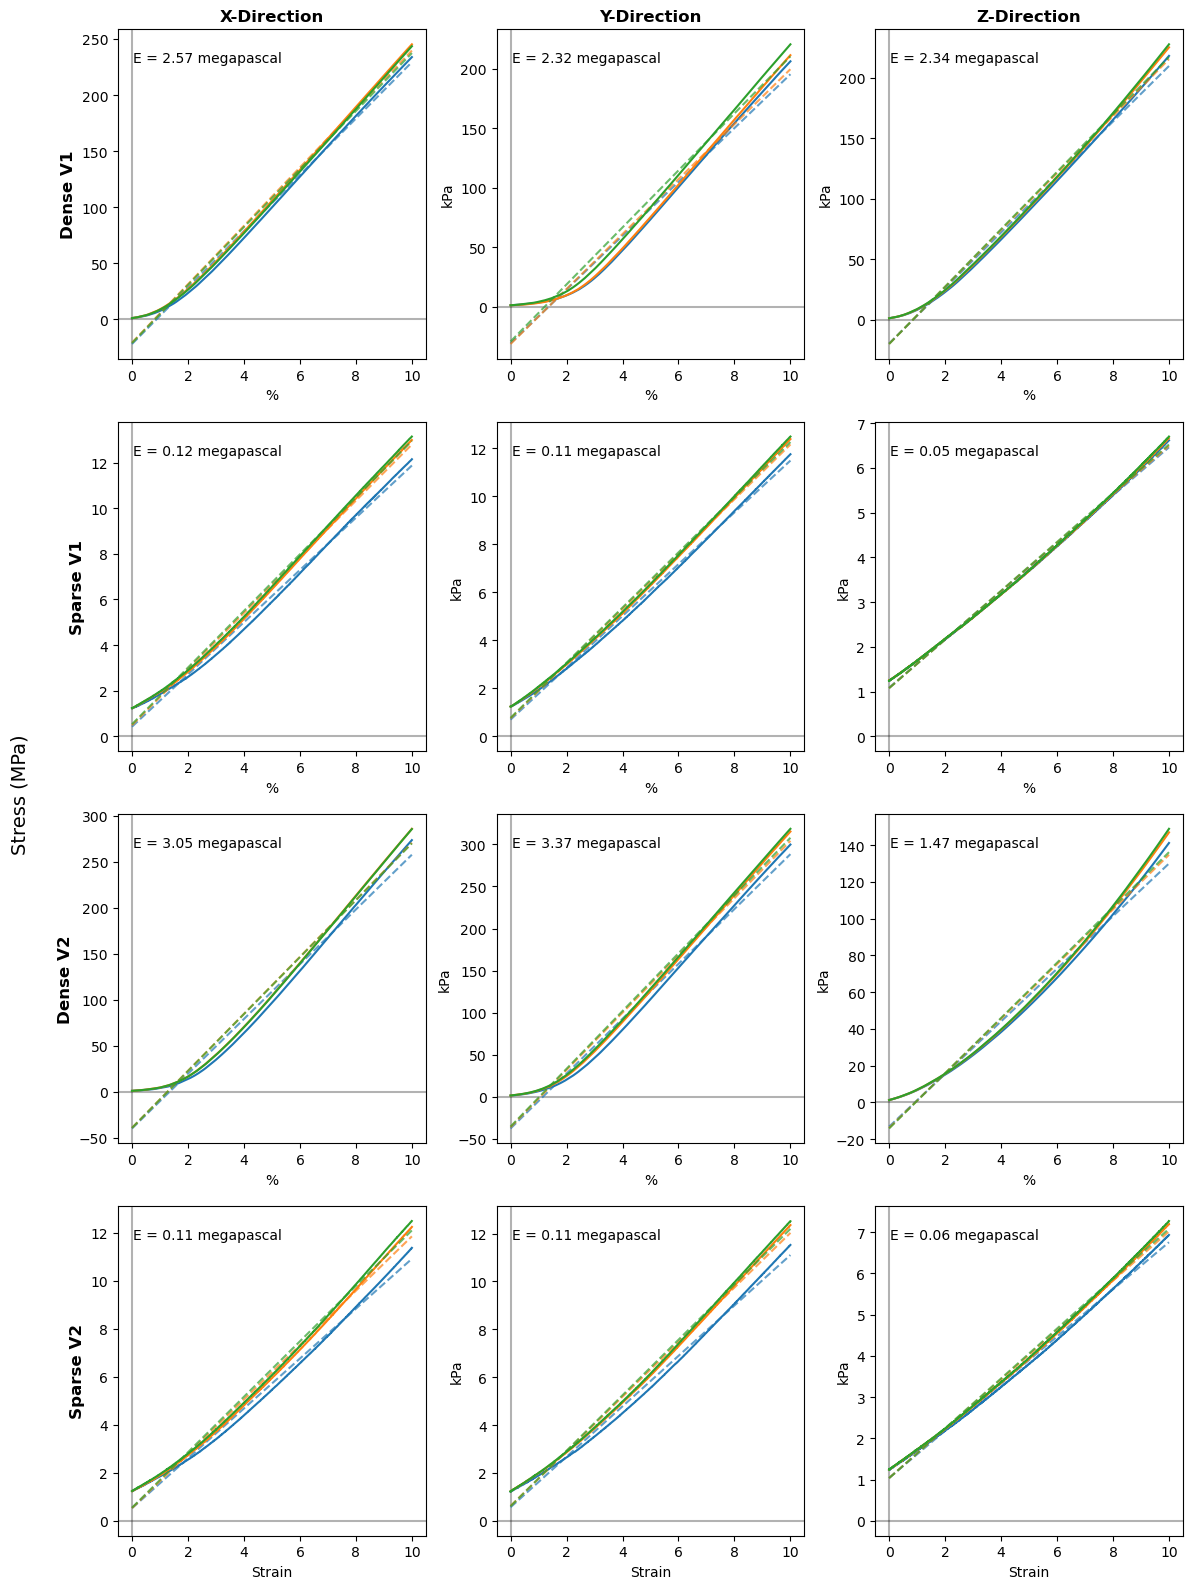

In [56]:
# Data to plot
x_col = 'Compressive strain (Displacement)'
y1_col = 'Compressive stress'
y2_col = 'Compressive stress (Line Fit)'
# x bounds of plot
strain_limits = (0., 0.1)

# Plotting
fig, axg = plt.subplots(4, 3, figsize=(12, 16))

# Add titles for columns (directions)
for j, direction in enumerate(directions):
    axg[0, j].set_title(f'{direction}-Direction', fontweight='bold')

# Add row labels (sample types)
for i, sample_type in enumerate(sample_types):
    # Create a more readable label
    label = sample_type.replace('_', ' ').title()
    axg[i, 0].set_ylabel(label, fontweight='bold', rotation=90, size=12)

# Plot data
for i in range(4):
    for j in range(3):
        ax = axg[i, j]
        ax.axvline(color='k', alpha=0.3)
        ax.axhline(color='k', alpha=0.3)

        # Plot each sample in this category
        samples_to_plot = organized_samples[i, j]
        for k, sample in enumerate(samples_to_plot):
            # Apply strain limits
            mask = ((sample.data[x_col] >= strain_limits[0]) &
                    (sample.data[x_col] <= strain_limits[1]))

            # Plot raw data
            ax.plot(sample.data[x_col][mask],
                    sample.data[y1_col][mask],
                    label=f'Sample {k+1}')

            # Plot linear fit if available
            if y2_col in sample.data.columns:
                ax.plot(sample.data[x_col][mask],
                        sample.data[y2_col][mask],
                        linestyle='--',
                        color=ax.lines[-1].get_color(),
                        alpha=0.7)

        # Add E value as text in each subplot
        if samples_to_plot:
            E_values = [s.user_data['E'] for s in samples_to_plot]
            avg_E = sum(E_values)/len(E_values) if E_values else 0
            ax.text(0.05, 0.9, f'E = {avg_E:.2f}', transform=ax.transAxes)

        # Set common x and y limits
        # ax.set_xlim(strain_limits * ureg.percent)

        # Only add x-labels to bottom row
        if i == 3:
            ax.set_xlabel('Strain')

# Add a common y-label
fig.text(0.01, 0.5, 'Stress (MPa)', va='center',
         rotation='vertical', fontsize=14)

plt.tight_layout()
plt.subplots_adjust(left=0.1)  # Make room for common y-label

# # Add a small legend to the bottom right subplot only
# if organized_samples[3, 2]:  # If there are samples in the bottom right
#     axg[3, 2].legend(loc='upper left', fontsize='small')

# Foam Metamaterials

These materials were topology optimized with the v2 parameters:
- Dense $V^*/H^*$: 0.15/6.93
- Sparse $V^*/H^*$: 0.4/14.81

In [57]:
dir = './metamaterials'
BULK_m2_2mmTransition = ip.load_samples(dir,
                                        filter_fn=lambda f: '2mm' in f.stem.lower())
BULK_m2_NoTransition = ip.load_samples(dir,
                                       filter_fn=lambda f: 'no' in f.stem.lower())

samples = [BULK_m2_2mmTransition, BULK_m2_NoTransition]

for group in samples:
    for s in group:
        m, b = s.add_linear_fit(x='Compressive strain (Displacement)',
                                y='Compressive stress',
                                x_min=0.,
                                x_max=5 * ureg.percent)
        s.user_data = dict(
            E=m.to('MPa'),
            y_intercept=b,
            comp_dir=s.results_tables[0]['Compression Axis']
        )

Loading csv files from ./metamaterials
6 found that match the filter
Loading csv files from ./metamaterials
6 found that match the filter


In [58]:
sample_types = ['2mm_Transition', 'No_Transition']
directions = ['X', 'Y']
nrows = len(sample_types)
ncols = len(directions)

organized_samples = np.empty((nrows, ncols), dtype=object)
for i in range(nrows):
    for j in range(ncols):
        organized_samples[i, j] = []

for i, group in enumerate(samples):
    for sample in group:
        dir_name = sample.user_data['comp_dir']
        dir_idx = {'X': 0, 'Y': 1}.get(dir_name, 0)
        organized_samples[i, dir_idx].append(sample)

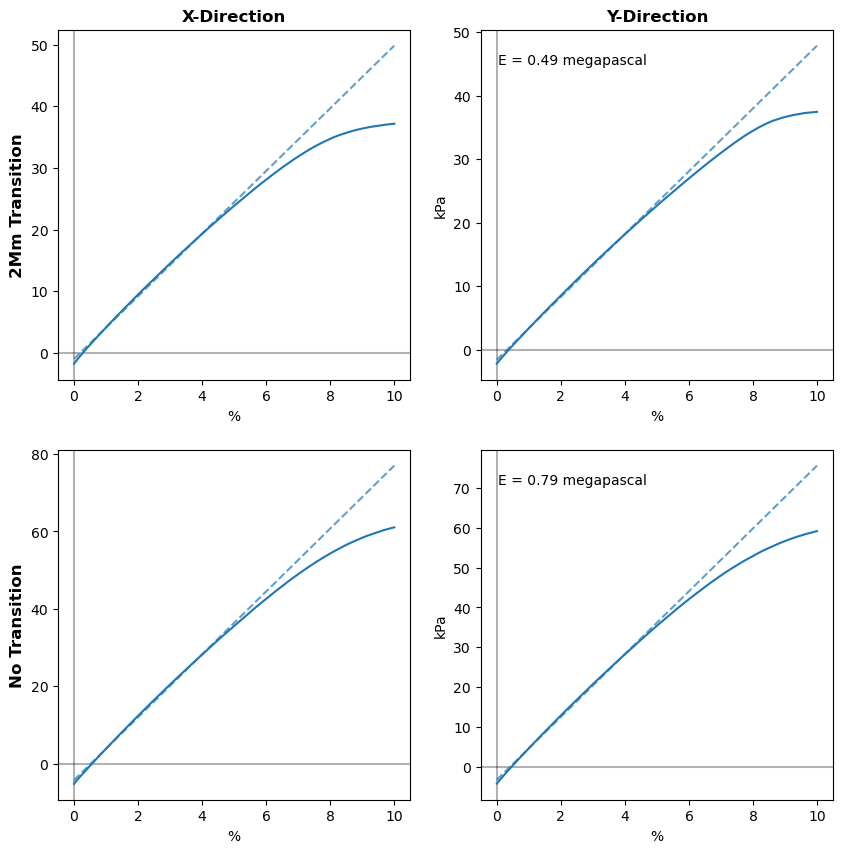

In [ ]:
# Data to plot
x_col = 'Compressive strain (Displacement)'
y1_col = 'Compressive stress'
y2_col = 'Compressive stress (Line Fit)'
# x bounds of plot
strain_limits = (0, 0.1)

fig, axg = plt.subplots(nrows, ncols, figsize=(10, 10))

for j, direction in enumerate(directions):
    axg[0, j].set_title(f'{direction}-Direction', fontweight='bold')

for i, sample_type in enumerate(sample_types):
    label = sample_type.replace('_', ' ').title()
    axg[i, 0].set_ylabel(label, fontweight='bold', rotation=90, size=12)

for i in range(nrows):
    for j in range(ncols):
        ax = axg[i, j]
        ax.axvline(color='k', alpha=0.3)
        ax.axhline(color='k', alpha=0.3)

        samples_to_plot = organized_samples[i, j]
        for k, sample in enumerate(samples_to_plot):
            print(sample)
            mask = ((sample.data[x_col] >= strain_limits[0]) &
                    (sample.data[x_col] <= strain_limits[1]))

            ax.plot(sample.data[x_col][mask],
                    sample.data[y1_col][mask],
                    label=f'Sample {k+1}')

        if y2_col in sample.data.columns:
            ax.plot(sample.data[x_col][mask],
                    sample.data[y2_col][mask],
                    linestyle='--',
                    color=ax.lines[-1].get_color(),
                    alpha=0.7)

    if samples_to_plot:
        E_values = [s.user_data['E'] for s in samples_to_plot]
        avg_E = sum(E_values)/len(E_values) if E_values else 0.
        ax.text(0.05, 0.9, f'E = {avg_E:.2f}', transform=ax.transAxes)

    if i == 2:
        ax.set_xlabel('Strain')